# Example 2 -- $C$ and $K$ with noise

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf
import seaborn as sns
# from simulation_v1 import *
from simulation_clust import *
from train_v1 import theoretical_C_K_obs
from estim_v1 import Optim_tf

from tick.hawkes import HawkesCumulantMatching
from tick.hawkes.inference.base import LearnerHawkesNoParam

from functions import compute_skew

import sys
sys.path.append('/home/users/ruan/ANotebook/spread/Models')
from dump_load import DataBox

In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## settings

In [53]:
#parameters setting
alpha = np.array([[0.1, 0.3, 0.1, 0], 
                  [0.3, 0., 0.1, 0.2],
                  [0.1, 0.1, 0, 0.3],
                  [0, 0.1, 0.2, 0.1]])
beta = 20

mu_tot = 1
#r is the proportion of exogenous order
r = 0.6
mu = (1-r) * mu_tot * np.ones((4))
lam = r * mu_tot * np.ones((2))
delay = 0.05
T = 2000
n_realizations = 100

print(np.linalg.eig(alpha)[0])

[ 0.49595141  0.18021064 -0.30207779 -0.17408426]


In [54]:
norm_phi = alpha
R = np.linalg.inv(np.eye(4) - norm_phi)
lamlam = np.concatenate((lam, lam))
Lp = R @ (mu + lamlam) # Lp[1] is the \Lambda price1+ process, sum of two processes
C = R @ (np.diag(Lp) + np.kron(np.array([[0,1],[1,0]]), np.diag(lam))) @ R.T

hawkes_to_price = np.array([[1, -1, 0, 0], [0, 0, 1, -1]])
Lam_price = np.array([[1, 1, 0, 0], [0, 0, 1, 1]]) @ Lp
C_price = hawkes_to_price @ C @ hawkes_to_price.T
correl_price = C_price[0,1] / np.sqrt(C_price[0,0] * C_price[1,1])
print('Cov micro:', Lam_price)
print('Cov macro:', C_price)
print('Corrélation:', correl_price)

Cov micro: [4.22035776 3.74544879]
Cov macro: [[2.9567275  1.15122286]
 [1.15122286 2.71649894]]
Corrélation: 0.4062084782433466


In [55]:
## theorical C and K values|
L_thr = tf.convert_to_tensor(Lp)
C_thr, K_thr = theoretical_C_K_obs(Lp, lamlam, R, only_ijj=True)

In [56]:
L_thr

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([2.05160678, 2.16875099, 1.95820801, 1.78724078])>

## simulation

In [57]:
simulating = True

In [58]:
if simulating :
    times = simulate(mu, lam, alpha*beta, np.ones_like(alpha)*beta, delay, T, n_realizations)

  0%|          | 0/100 [00:00<?, ?it/s]

## estimated C and K from data

In [59]:
if simulating:
    for i in range(n_realizations):
        for j,ts in enumerate(times[i]):
            times[i][j] = np.array(ts)

In [60]:
if simulating : 
    integration_support = 1 # H 
    nphc = HawkesCumulantMatching(integration_support, 
                                  cs_ratio=.15, 
                                  tol=1e-10, 
                                  step=0.3)
    LearnerHawkesNoParam.fit(nphc, times, end_times=np.ones(len(times))*T)
    cumcal = nphc._cumulant_computer
    # estimate moments tick
    # estimator Λ
    cumcal.compute_L()
    L_est = cumcal.L
    # estimator C
    cumcal.compute_C_and_J()
    C_est = cumcal.C
    # estimator K
    K_est = compute_skew(cumcal)

In [61]:
if simulating :
    print(L_est, Lp)
    print(C_est, C_thr)    
    print(tf.linalg.diag_part(K_est))

[2.05738  2.173165 1.95161  1.762065] [2.05160678 2.16875099 1.95820801 1.78724078]
[[4.25792239 2.82789264 2.26504676 1.51330175]
 [2.82789264 4.35898687 2.13042546 2.50946759]
 [2.26504676 2.13042546 3.29770232 2.01211669]
 [1.51330175 2.50946759 2.01211669 3.38991502]] tf.Tensor(
[[4.21427949 2.77682021 2.2798365  1.41128453]
 [2.77682021 4.29608843 2.12882822 2.41149911]
 [2.2798365  2.12882822 3.3516221  1.96315991]
 [1.41128453 2.41149911 1.96315991 3.29119665]], shape=(4, 4), dtype=float64)
tf.Tensor(
[[13.72097129  9.27054276  5.24297293  3.94769771]
 [ 9.43202596 13.1268406   5.61804748  6.54120324]
 [ 6.28169465  6.45543904  8.31782555  5.90567328]
 [ 4.539149    6.96854807  5.58008126  9.73135157]], shape=(4, 4), dtype=float64)


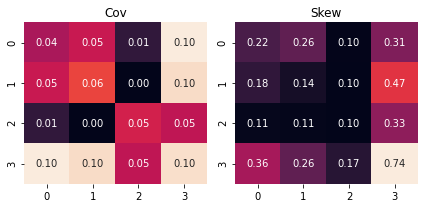

In [62]:
fig, axes = plt.subplots(1,2,figsize=(6,3))
sns.heatmap(np.abs(C_thr-C_est), ax=axes[0], annot=True, fmt='.2f', cbar=False)
sns.heatmap(np.abs(K_thr-tf.linalg.diag_part(K_est)), ax=axes[1], annot=True, fmt='.2f', cbar=False)
for i,mtx in enumerate(['Cov', 'Skew']):
    axes[i].set_title('%s'%(mtx))
fig.tight_layout()

## optimization

In [63]:
opt = Optim_tf(4)
L_obs = tf.convert_to_tensor(L_est)
C_obs = tf.convert_to_tensor(C_est)
K_obs = tf.convert_to_tensor(tf.linalg.diag_part(K_est))
opt.set_L_C_K(L_obs, C_obs, K_obs)

0.895854234641341


In [64]:
# C_obs, K_obs

In [65]:
opt.set_init_value()
opt.set_variables()

[ 0.27103921 -0.05561173 -0.00618941  0.11127682]


In [72]:
opt.train(print_every=500, n_iter=5000)

Iter:  500
Loss:  87.58685933717676
Iter:  1000
Loss:  79.74955450883982
Iter:  1500
Loss:  74.57854269651872
Iter:  2000
Loss:  70.91561387414694
Iter:  2500
Loss:  67.93887062703446
Iter:  3000
Loss:  65.3305005107195
Iter:  3500
Loss:  63.20266613998306
Iter:  4000
Loss:  61.76319979334073
Iter:  4500
Loss:  61.02860093544209
Iter:  5000
Loss:  60.77064992023463


[<tf.Variable 'R:0' shape=(4, 4) dtype=float64, numpy=
 array([[1.2102275 , 0.56159288, 0.25066502, 0.06147225],
        [0.32264551, 1.20863292, 0.23122455, 0.3452868 ],
        [0.11816907, 0.26072767, 1.14523301, 0.39478105],
        [0.137556  , 0.16218804, 0.28331997, 1.26437171]])>,
 <tf.Variable 'L:0' shape=(2,) dtype=float64, numpy=array([0.63830132, 0.63851758])>]

In [73]:
opt.mu_opt = np.linalg.inv(opt.R_opt)@opt.L_obs.numpy() - np.block([opt.L_opt,opt.L_opt])
print(opt.L_opt, lam)
print(opt.mu_opt, mu)

[0.63830132 0.63851758] [0.6 0.6]
[0.2945099  0.448332   0.40538164 0.28034273] [0.4 0.4 0.4 0.4]


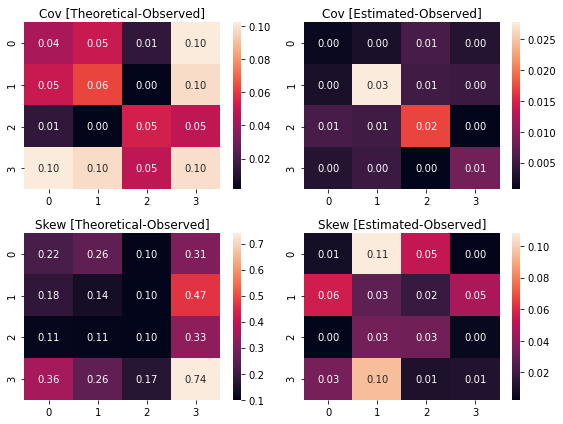

In [74]:
opt.reconstruct_C_K()
fig, axes = plt.subplots(2,2,figsize=(8,6))
sns.heatmap(np.abs(C_thr-opt.C_obs), ax=axes[0,0],annot=True, fmt='.2f')
sns.heatmap(np.abs(opt.C_obs-opt.C_opt), ax=axes[0,1],annot=True, fmt='.2f')
sns.heatmap(np.abs(K_thr-opt.K_obs), ax=axes[1,0],annot=True, fmt='.2f')
sns.heatmap(np.abs(opt.K_obs-tf.linalg.diag_part(opt.K_opt)), ax=axes[1,1],annot=True, fmt='.2f')
for i,mtx in enumerate(['Cov', 'Skew']):
    for j, err in enumerate(['Theoretical-Observed','Estimated-Observed']):
        axes[i,j].set_title('%s [%s]'%(mtx,err))
fig.tight_layout()

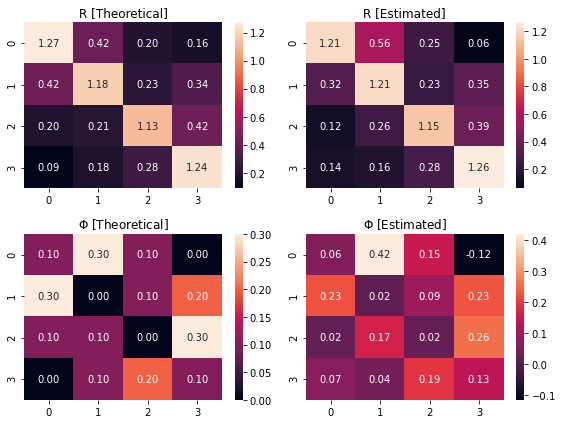

In [75]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
sns.heatmap(R, ax=axes[0,0],annot=True, fmt='.2f')
sns.heatmap(opt.R_opt, ax=axes[0,1],annot=True, fmt='.2f')
sns.heatmap(alpha, ax=axes[1,0],annot=True, fmt='.2f')
sns.heatmap(opt.phi_opt, ax=axes[1,1],annot=True, fmt='.2f')
for i,mtx in enumerate(['R', r'$\Phi$']):
    for j, err in enumerate(['Theoretical','Estimated']):
        axes[i,j].set_title('%s [%s]'%(mtx,err))
fig.tight_layout()

<AxesSubplot:>

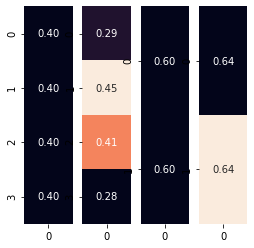

In [76]:
fig, axes = plt.subplots(1,4,figsize=(4,4))
sns.heatmap(np.expand_dims(mu,1), ax=axes[0],annot=True, fmt='.2f', cbar=False)
sns.heatmap(np.expand_dims(opt.mu_opt,1), ax=axes[1],annot=True, fmt='.2f', cbar=False)
sns.heatmap(np.expand_dims(lam,1), ax=axes[2],annot=True, fmt='.2f', cbar=False)
sns.heatmap(np.expand_dims(opt.L_opt,1), ax=axes[3],annot=True, fmt='.2f', cbar=False)